In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
sns.set(font_scale=2)

#split data
from sklearn.model_selection import train_test_split

# scaling data, normalisasi dan encode
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

# metode untuk data yang tidak seimbang
from imblearn.over_sampling import SMOTE

# prediksi model kita
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#evaluasi matrix
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
#evaluasi plot
from yellowbrick.classifier import (
    DiscriminationThreshold,
    PrecisionRecallCurve
)


#### Membaca data dan statistik deskriptifnya
jadi ini akan di menghapus fitur 'Complain', karena sangat mirip dengan variabel target 'Exited'. Bisa jadi pelanggan mengeluh sesaat sebelum berangkat, sehingga variabel ini tidak terlalu membantu kita dalam memprediksi.

In [30]:
data = pd.read_csv('Churn_Modelling.csv') #https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn?resource=download
data = data.drop('Complain',axis=1)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


In [31]:
display(data.describe())
display(data.describe(include='object'))

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Point Earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,5.000000,1000.000000


,Surname,Geography,Gender,Card Type
count,10000,10000,10000,10000
unique,2932,3,2,4
top,Smith,France,Male,DIAMOND
freq,32,5014,5457,2507


#### cek missing values nya 

In [32]:
# cek missing values
data.isnull().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

#### Memastikan setiap ID pelanggan hanya muncul satu kali

In [33]:
data['CustomerId'].value_counts(ascending=False)

15634602    1
15667932    1
15766185    1
15667632    1
15599024    1
           ..
15599078    1
15702300    1
15660735    1
15671390    1
15628319    1
Name: CustomerId, Length: 10000, dtype: int64

#### ngekelompokan fitur ke kategorikal dan numerik sama misahin data buat dilatih dan diuji

In [34]:
to_remove = ['CustomerId', 'RowNumber', 'Surname']
data = data.drop(columns=to_remove)
# pemisahan cepat ke fitur kategorikal dan numerik
target = ['Exited']
cat_feats = ['Geography', 'Gender', 'Card Type', 'Satisfaction Score', 'IsActiveMember', 'HasCrCard']
num_feats = [col for col in data if col not in (cat_feats+target)]


In [35]:
X = data.drop(target, axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#validasi
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 13), (2000, 13), (8000,), (2000,))

#### EDA (Exploratory Data Analysis)

0    0.79625
1    0.20375
Name: Exited, dtype: float64

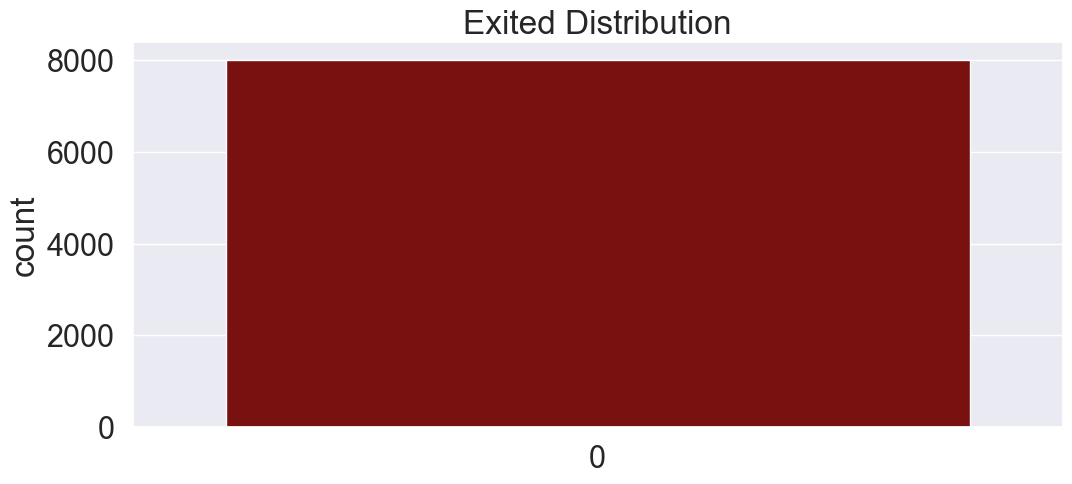

In [36]:
f = plt.figure(figsize=(12,5))

sns.countplot(y_train, color='darkred')
plt.title('Exited Distribution')

display(y_train.value_counts(normalize=True))

alert!!!! punya kasus yang ga seimbang ini AWASS

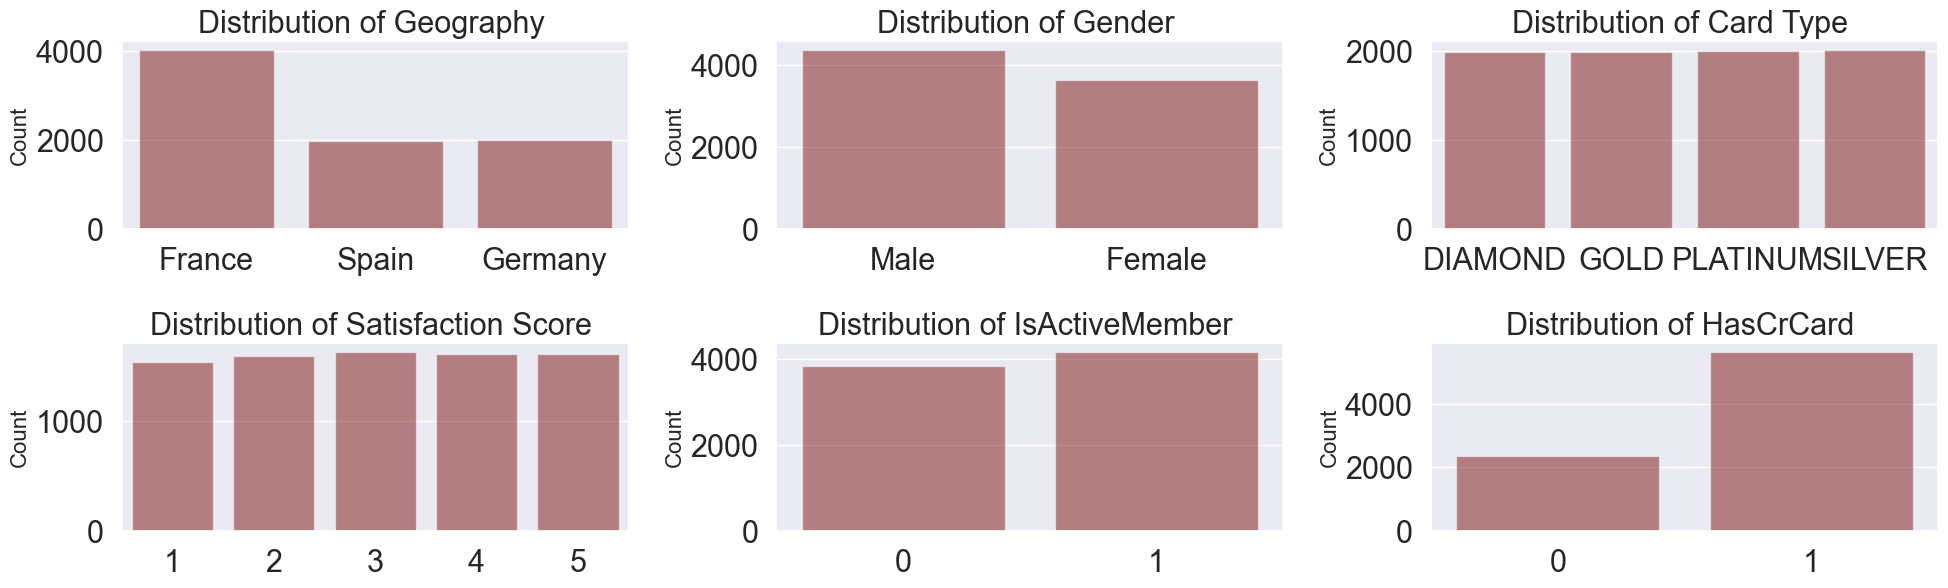

In [37]:
# merencanakan distribusi variabel kategori
f = plt.figure(figsize=(20,15))

for i, col in enumerate(cat_feats):


    plt.subplot(5,3, i+1)
    if len(X_train[col].unique()) <= 5:
        sns.countplot(data=X_train, x=col, color='darkred', alpha=0.5)
        plt.ylabel("Count", fontdict={'fontsize':16})
    else:
        sns.countplot(data=X_train, y=col, order=X_train[col].value_counts().index,color='darkred',alpha=0.5)
    plt.title(f"""Distribution of {col} """, fontdict={'fontsize':22})
    plt.xlabel("")
    #plt.ylabel("")

plt.tight_layout()
plt.savefig("Categorical distributions")
plt.show()

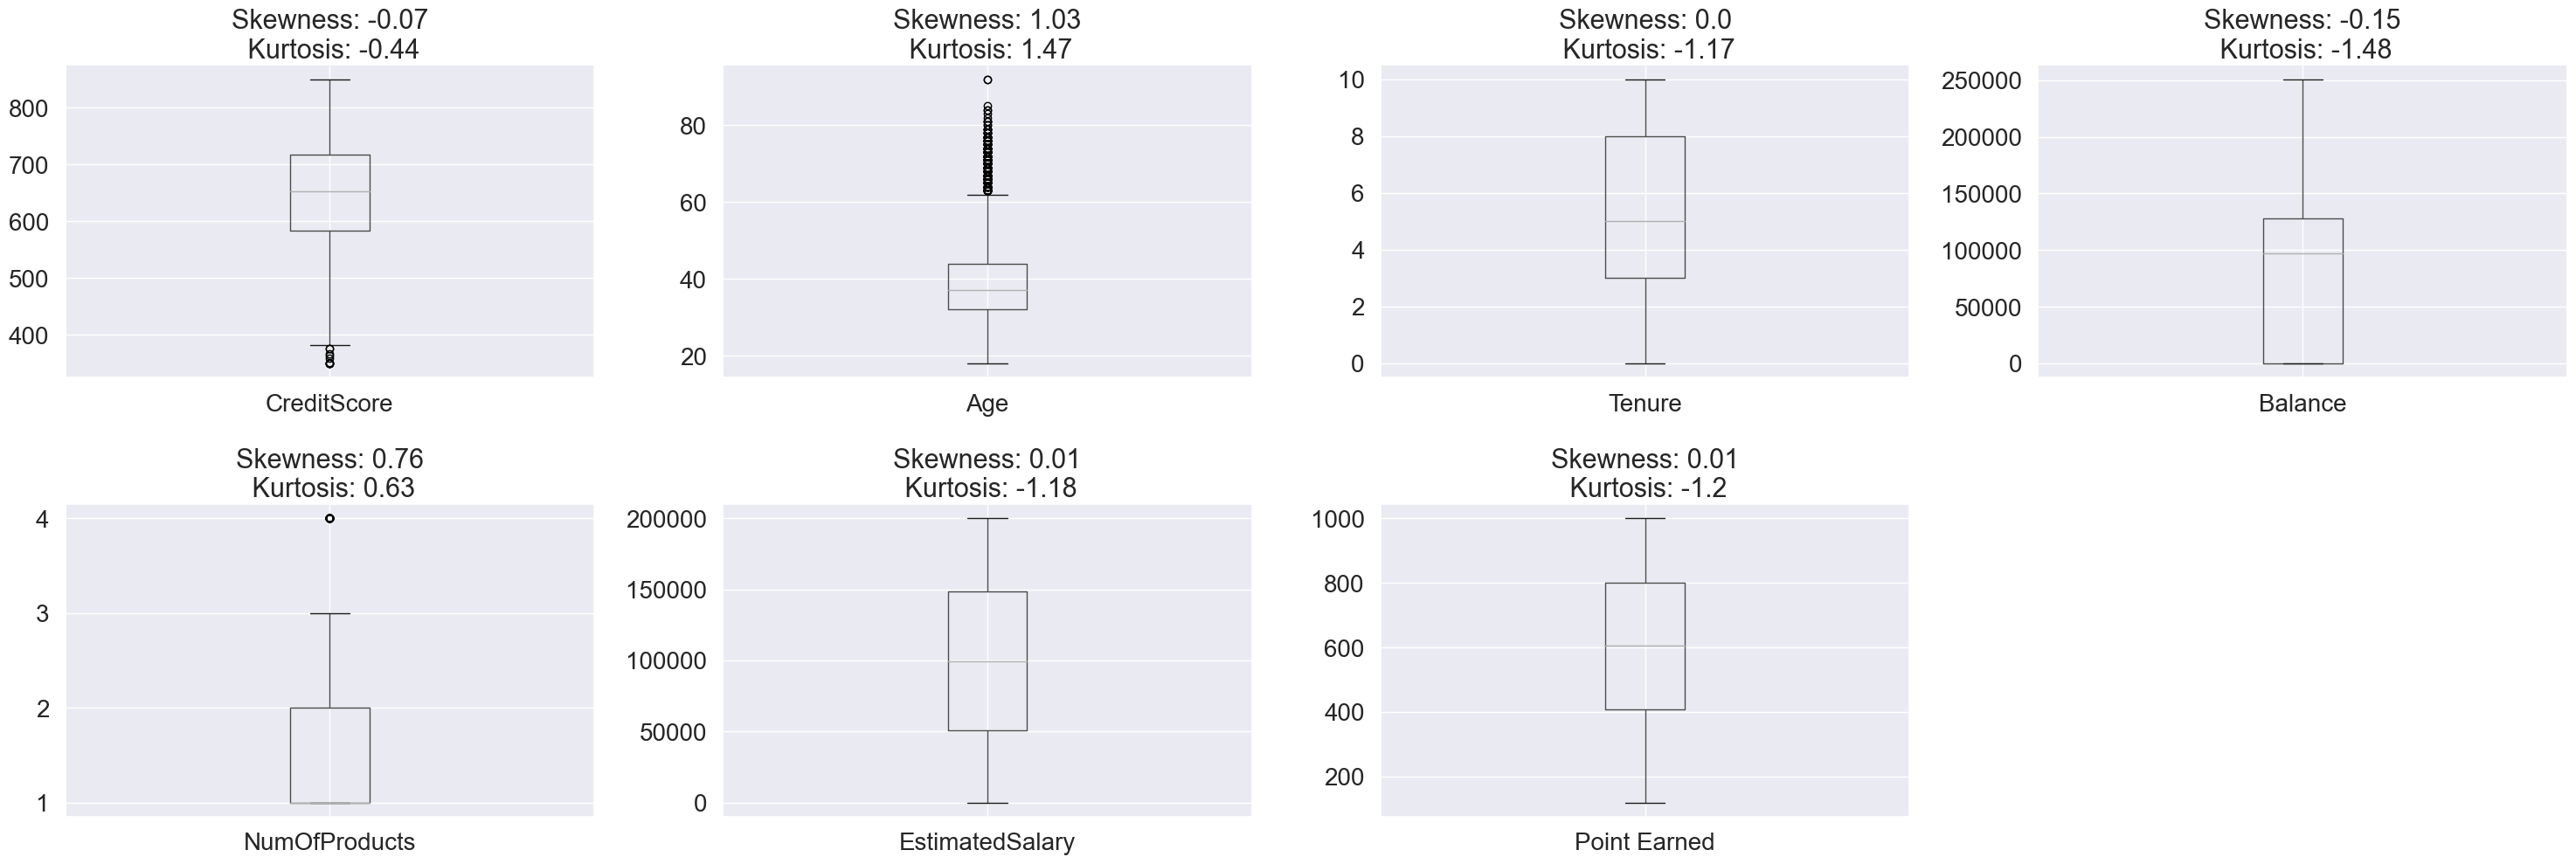

In [38]:
# merencanakan distribusi variabel numerik
sns.set_style("darkgrid")
plt.figure(figsize=(30,15))
for i,col in enumerate(num_feats):
    plt.subplot(3,4,i+1)
    X_train[[col]].boxplot(fontsize=20)
    plt.title(f'Skewness: {np.round(X_train[col].skew(),2)}\n Kurtosis: {np.round(X_train[col].kurt(),2)}',
              fontdict={'fontsize':22})
    plt.savefig("cont variables")
    plt.tight_layout();

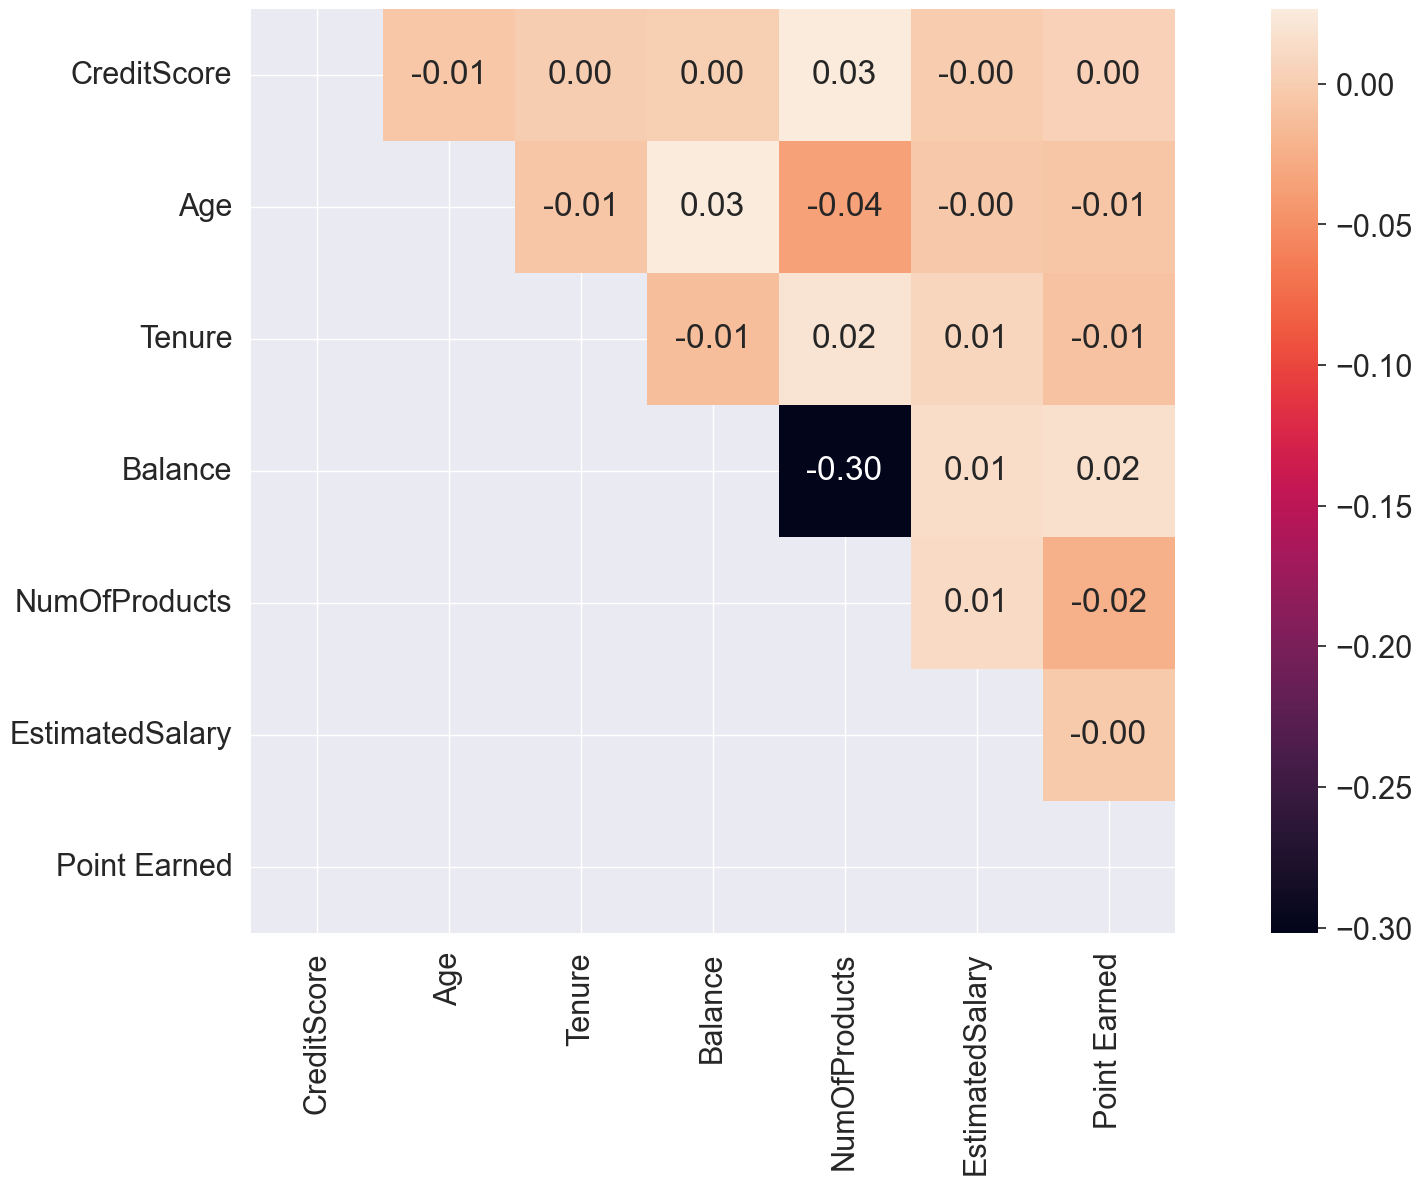

In [39]:
#correlation matrix
corr = X_train[num_feats].corr()

plt.figure(figsize=(25,12))
mask = np.tril(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt=".2f", mask = mask, square = True)
plt.show()

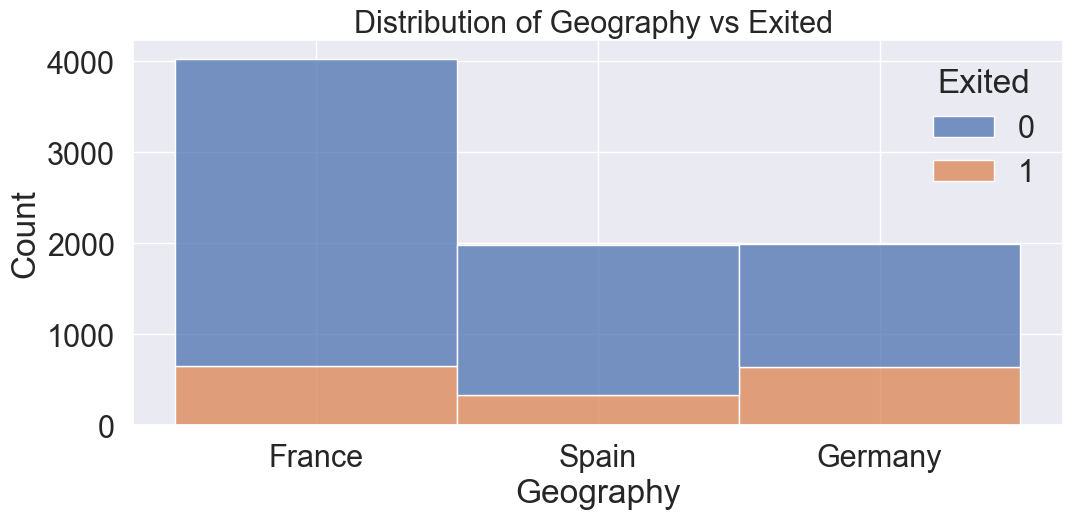

Overall frequency: 


France     0.50375
Germany    0.24900
Spain      0.24725
Name: Geography, dtype: float64

**************************************************


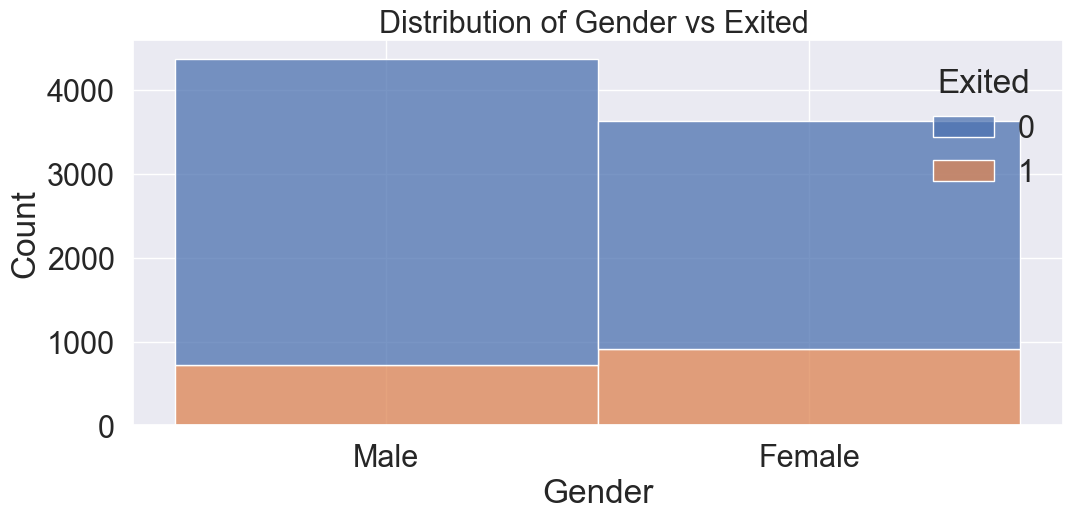

Overall frequency: 


Male      0.5465
Female    0.4535
Name: Gender, dtype: float64

**************************************************


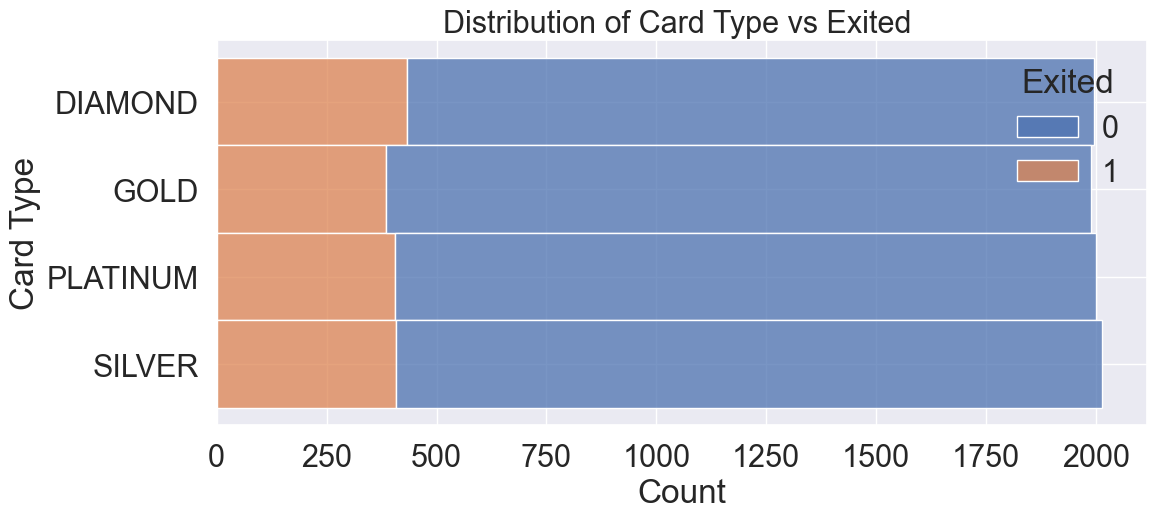

Overall frequency: 


SILVER      0.251875
PLATINUM    0.250125
DIAMOND     0.249500
GOLD        0.248500
Name: Card Type, dtype: float64

**************************************************


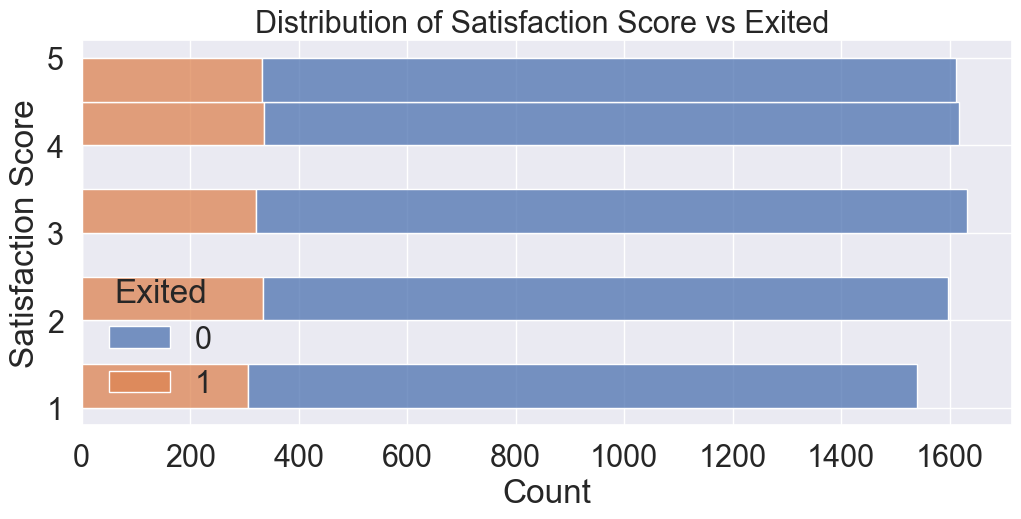

Overall frequency: 


3    0.204125
4    0.202250
5    0.201500
2    0.199625
1    0.192500
Name: Satisfaction Score, dtype: float64

**************************************************


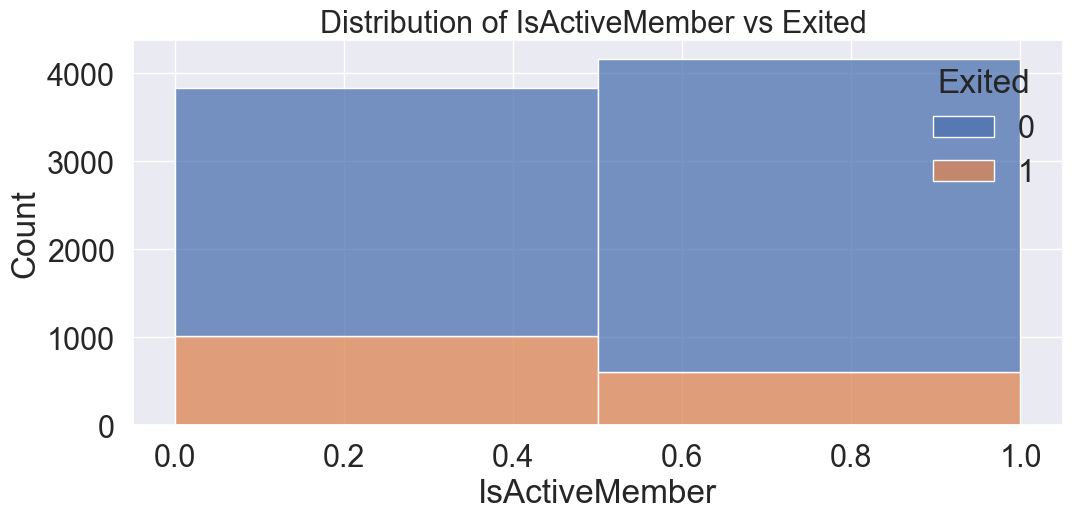

Overall frequency: 


1    0.520875
0    0.479125
Name: IsActiveMember, dtype: float64

**************************************************


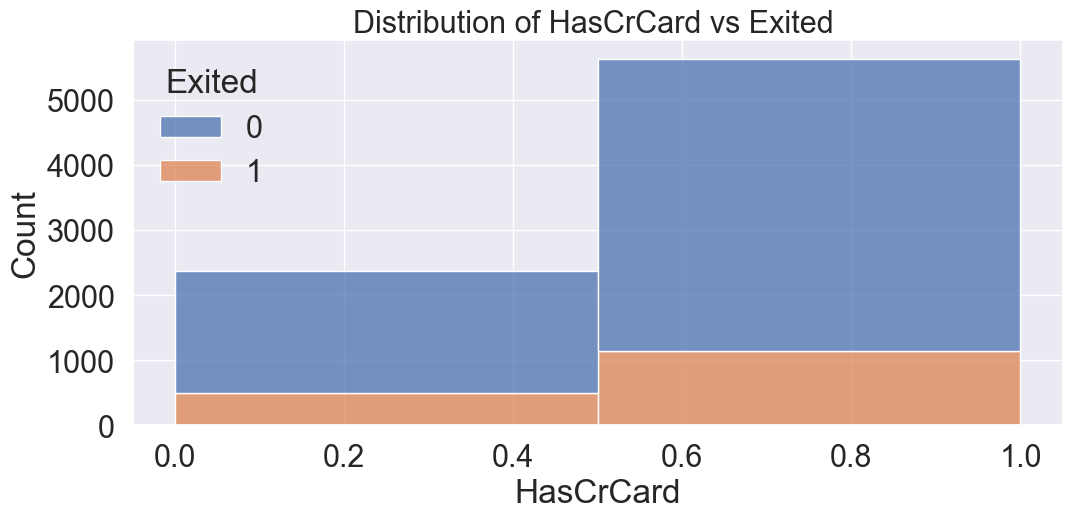

Overall frequency: 


1    0.703875
0    0.296125
Name: HasCrCard, dtype: float64

**************************************************


In [40]:
# Variabel target vs prediktor kategori

df_train = pd.concat([X_train, y_train],axis=1)


for col in cat_feats:
    if col in df_train.columns:
        plt.figure(figsize=(12,5))
        if len(X_train[col].unique()) < 4:
            sns.histplot(binwidth=0.5, x=col, hue=y_train, data=X_train, stat="count", multiple="stack", bins=10)
        else:
            sns.histplot(binwidth=0.5, y=col, hue=y_train, data=X_train, stat="count", multiple="stack", bins=10)
        plt.title(f"""Distribution of {col} vs Exited """, fontdict={'fontsize':22})
        plt.show()

        print('Overall frequency: ')
        display(X_train[col].value_counts(normalize=True))

        print()

        unique_values = df_train[col].unique()
        odds_dict = {}
        for unique_val in unique_values:
            is_claimed_vals = len(df_train.loc[(df_train['Exited']==1) & (df_train[col]==unique_val)])
            is_not_claimed_vals = len(df_train.loc[(df_train['Exited']==0) & (df_train[col]==unique_val)])
            odds_dict[unique_val] = round(is_claimed_vals/(is_not_claimed_vals+0.000001)*100, 2)

        odds_df = pd.Series(odds_dict, name=f'{col}_odds_ratio - Exited/Not Exited (%)').reset_index() \
            .rename(columns={'index':'Categories'})

        fig = go.Figure(data=[go.Table(
            header=dict(values=list(odds_df.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[odds_df[val] for val in odds_df.columns],
                       fill_color='lavender',
                       align='left'))
        ])
        fig.update_layout(
            autosize=False)
        fig.show()

        print('*'*50)

Komentar:
 - nah ini kita dapat melihat bahwa si rasio odds untuk pelanggan yang keluar vs tidak keluar lebih tinggi di Jerman, jadi si Geografi ini dapat membantu kita memahami beberapa alasan churn pelanggan.
- terus kita juga dapat melihat bahwa rasio odds untuk pelanggan yang keluar vs tidak keluar lebih tinggi di kelompok perempuan (Gender), jadi si Gender ini membantu memahami beberapa alasan churn pelanggan (Lebih banyak perempuan meninggalkan bank).

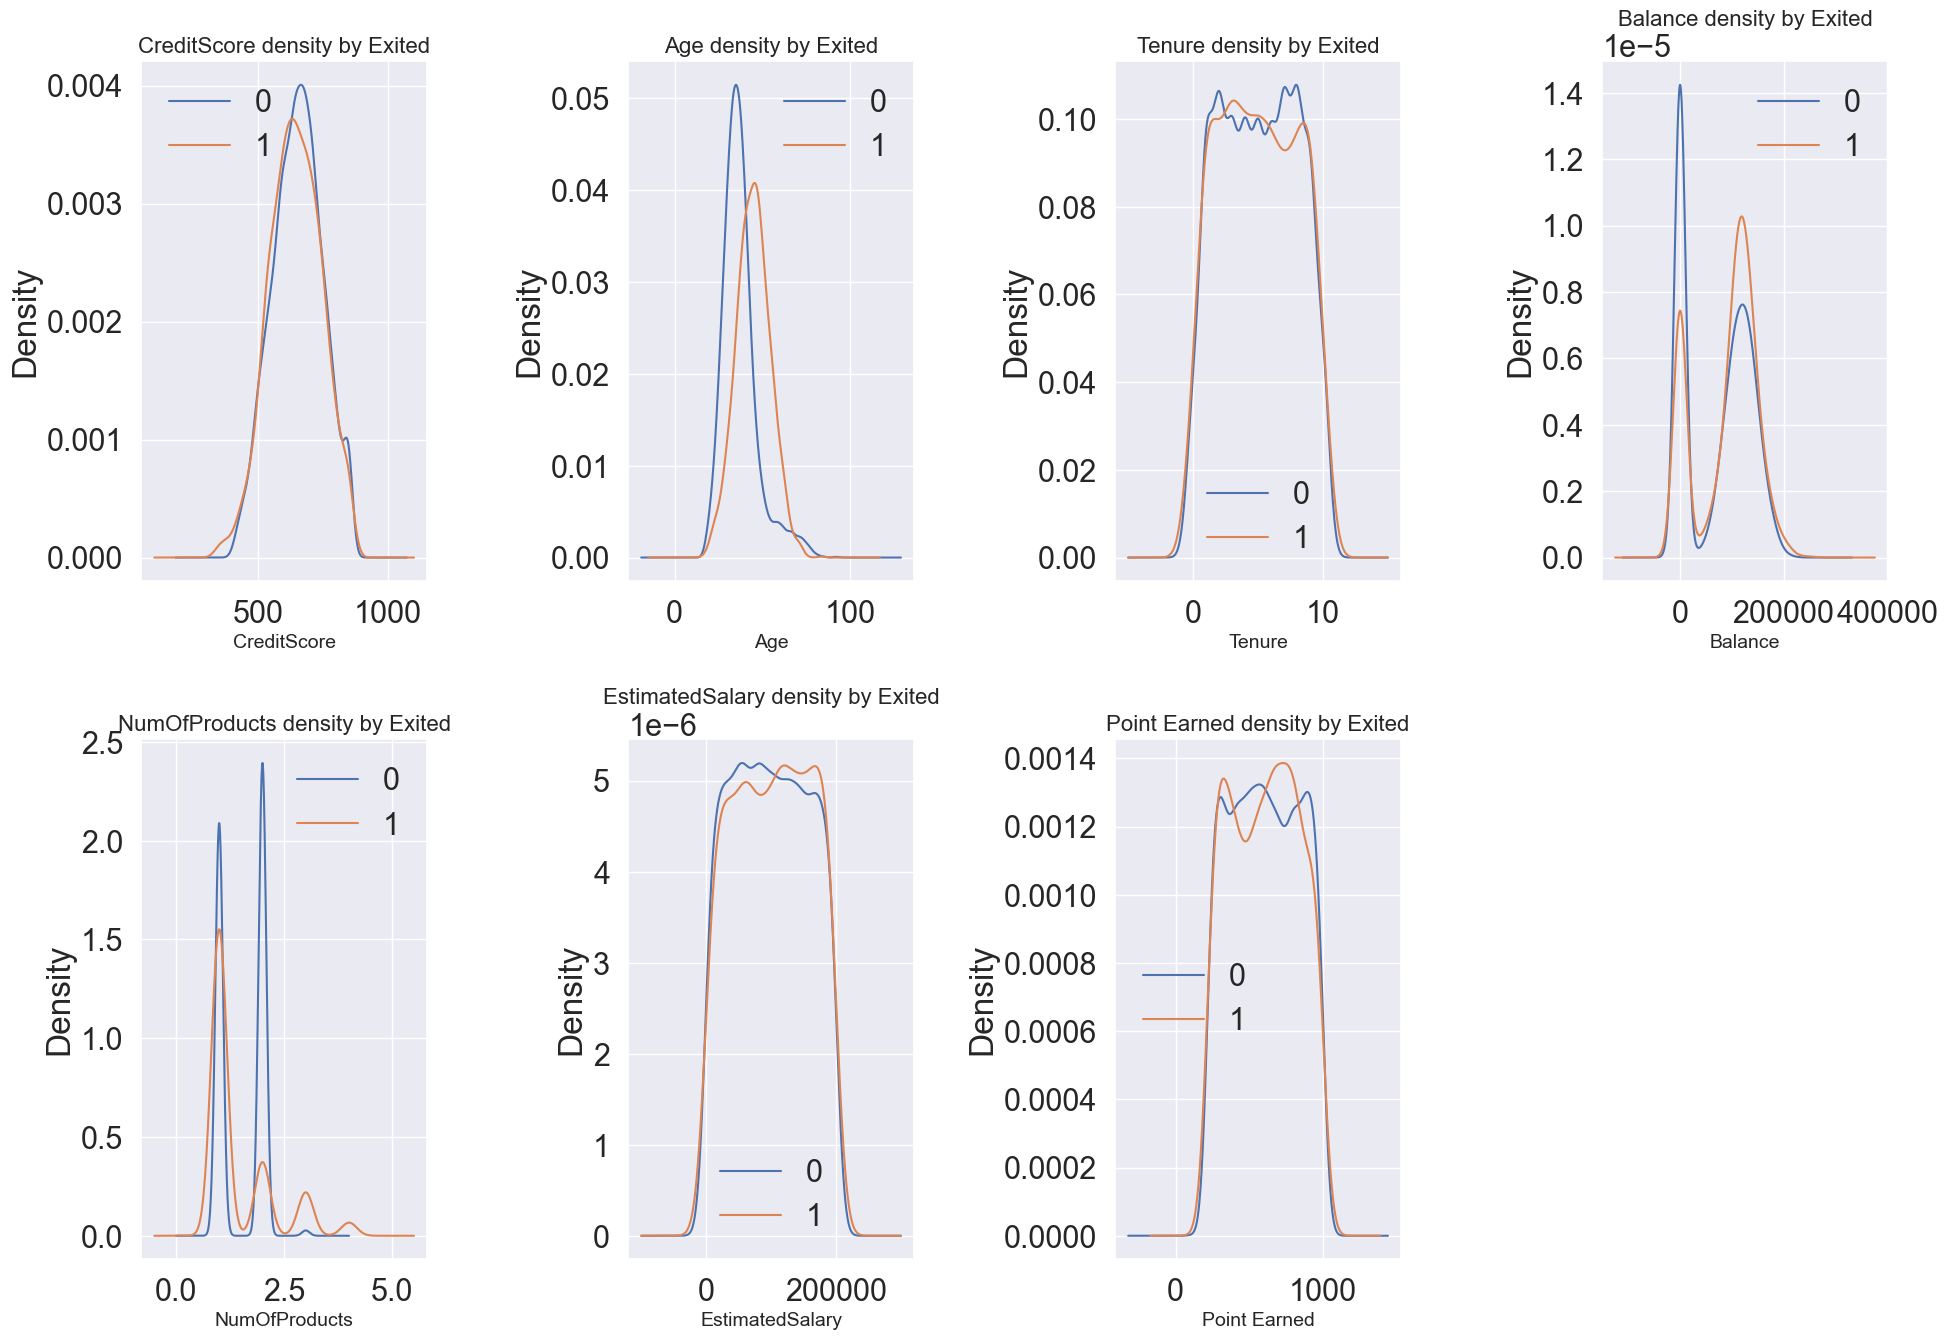

In [41]:
# Fitur yang diprediksi vs fitur numerik

df_train = pd.concat([X_train, y_train],axis=1)
#f = plt.figure(figsize=(20,20))

for i, col in enumerate(num_feats):
    plt.subplot(3,4, i+1)

    df_train.groupby('Exited')[col].plot(kind='kde', figsize=(20, 20))
    plt.legend()
    plt.title(col + ' density by Exited',fontdict={'fontsize':16})
    plt.xlabel(col,fontdict={'fontsize':14})

plt.tight_layout()
plt.savefig("numerical vs Exited")
plt.show()

Komentar:
 - nah liat yah disini ada perbedaan jumlah pelanggan yang keluar dan pelanggan yang tidak. si pelanggan yang lebih tua cenderung lebih sering melakukan churn.

#### Preprocessing
1) one hot encoding to nominal categorical fitur
2) Mapping kategorikal ordinal yang perlu di mapped.
3) Min Max scaling datanya

In [42]:
# fitur kategoris yang relevan
nominal_cat_feats = ['Gender', 'Geography']

One hot encoding -

In [43]:
encoder = OneHotEncoder(sparse_output=False)
nominal_mat = encoder.fit_transform(X_train[nominal_cat_feats])
nominal_df = pd.DataFrame(nominal_mat,
                          columns=encoder.get_feature_names_out(),
                          index=X_train.index)

X_train = X_train.drop(columns=nominal_cat_feats)
X_train = pd.concat([X_train, nominal_df],axis=1)

In [44]:
nominal_mat_test = encoder.transform(X_test[nominal_cat_feats])
nominal_df_test = pd.DataFrame(nominal_mat_test,
                               columns=encoder.get_feature_names_out(),
                               index=X_test.index)

X_test = X_test.drop(columns=nominal_cat_feats)
X_test = pd.concat([X_test, nominal_df_test],axis=1)

Ordinal encoding mapping -

In [45]:
encoder = OrdinalEncoder(categories=[np.array(['SILVER','GOLD', 'PLATINUM','DIAMOND'],dtype=object)])
X_train['Card Type'] = encoder.fit_transform(X_train[['Card Type']])
X_test['Card Type'] = encoder.transform(X_test[['Card Type']])

Min Max scaler

In [46]:
sc = MinMaxScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)


karena ada data yang kelebihan, jadi coba pake SMOTE method

KENAPA PAKE SMOTE :

karena SMOTE adalah teknik oversampling di mana sampel sintetik dihasilkan untuk kelas minoritas. Algoritme ini membantu mengatasi masalah overfitting yang ditimbulkan oleh random oversampling.

In [47]:
sm = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5
)

X_res, y_res = sm.fit_resample(X_train_sc, y_train)

#### Modeling

random forest

In [48]:
rf = RandomForestClassifier()
rf.fit(X_res, y_res)

preds = rf.predict(X_test_sc)

#### Model Evaluation

In [49]:
print('F-measure Random Forest test:', f1_score(y_test, preds, pos_label=1))
print('Recall Random Forest test:', recall_score(y_test, preds, pos_label=1))
print('Precision Random Forest test:', precision_score(y_test, preds))


F-measure Random Forest test: 0.6359102244389028
Recall Random Forest test: 0.625
Precision Random Forest test: 0.6472081218274112


In [50]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1592
           1       0.65      0.62      0.64       408

    accuracy                           0.85      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.85      0.85      0.85      2000



c:\Users\Irham Ahmad M\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



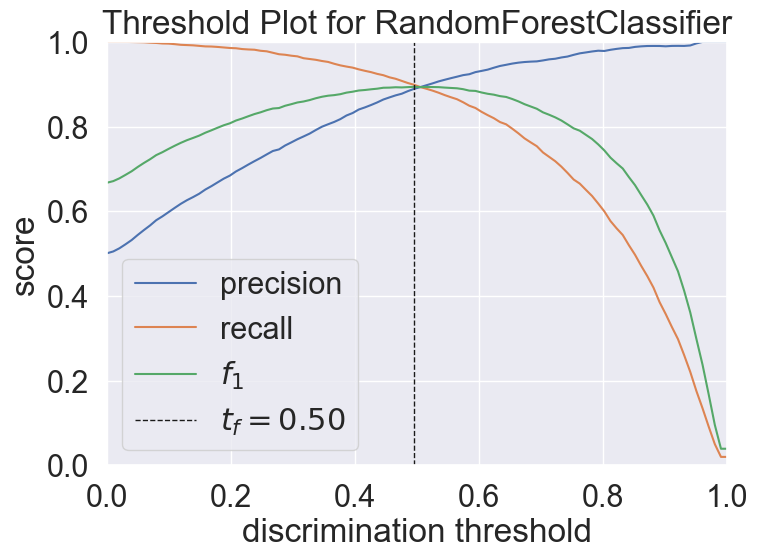

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [51]:
visualizer = DiscriminationThreshold(rf,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_res, y_res)        # Sesuaikan visualisasinya dan modelnya
visualizer.score(X_test_sc, y_test)        # Evaluasi model pada data uji
visualizer.show()

c:\Users\Irham Ahmad M\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



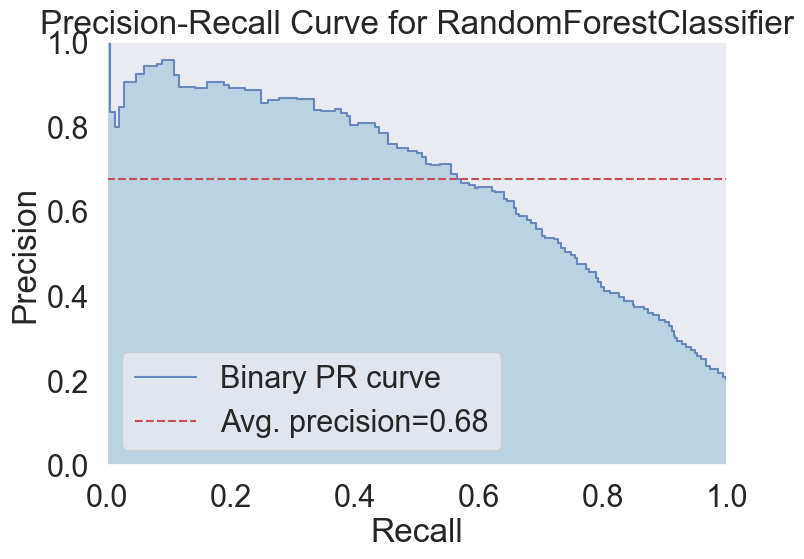

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [52]:
visualizer = PrecisionRecallCurve(rf, classes=[0, 1])

visualizer.fit(X_res, y_res)        # Sesuaikan data pelatihan ke visualisasi
visualizer.score(X_test_sc, y_test)        # Evaluasi model pada data uji
visualizer.show()                      

# XGBoost

latih modelnya dulu

In [53]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_res, y_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

prediksi model

In [54]:
xgb_preds = xgb.predict(X_test_sc)


evaluasi model

In [55]:
print('F-measure XGBoost test:', f1_score(y_test, xgb_preds, pos_label=1))
print('Recall XGBoost test:', recall_score(y_test, xgb_preds, pos_label=1))
print('Precision XGBoost test:', precision_score(y_test, xgb_preds))

print(classification_report(y_test, xgb_preds))


F-measure XGBoost test: 0.6394736842105263
Recall XGBoost test: 0.5955882352941176
Precision XGBoost test: 0.6903409090909091
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1592
           1       0.69      0.60      0.64       408

    accuracy                           0.86      2000
   macro avg       0.80      0.76      0.78      2000
weighted avg       0.86      0.86      0.86      2000



In [59]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Membuat DataFrame untuk menyimpan metrik kinerja
performance_metrics = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'Accuracy'])

# Menambahkan metrik kinerja untuk Random Forest
performance_metrics = performance_metrics.append({
    'Model': 'Random Forest',
    'Precision': precision_score(y_test, preds),
    'Recall': recall_score(y_test, preds),
    'Accuracy': accuracy_score(y_test, preds)
}, ignore_index=True)

# Menambahkan metrik kinerja untuk XGBoost
performance_metrics = performance_metrics.append({
    'Model': 'XGBoost',
    'Precision': precision_score(y_test, xgb_preds),
    'Recall': recall_score(y_test, xgb_preds),
    'Accuracy': accuracy_score(y_test, xgb_preds)
}, ignore_index=True)

# Cetak tabel metrik kinerja dalam format Markdown
print(performance_metrics.to_markdown(index=False))


| Model         |   Precision |   Recall |   Accuracy |
|:--------------|------------:|---------:|-----------:|
| Random Forest |    0.647208 | 0.625    |      0.854 |
| XGBoost       |    0.690341 | 0.595588 |      0.863 |


C:\Users\Irham Ahmad M\AppData\Local\Temp\ipykernel_19416\528141030.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Irham Ahmad M\AppData\Local\Temp\ipykernel_19416\528141030.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
from sklearn.model_selection import GridSearchCV

# Definisikan hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Inisialisasi model
xgb = XGBClassifier()

# Inisialisasi Grid Search dengan Cross Validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)

# Lakukan fitting pada data training
grid_search.fit(X_res, y_res)

# Print parameter terbaik yang ditemukan
print("Parameter terbaik:", grid_search.best_params_)

# Prediksi dengan model terbaik
xgb_best = grid_search.best_estimator_
xgb_best_preds = xgb_best.predict(X_test_sc)

# Evaluasi performa model terbaik
print('F-measure XGBoost test (after tuning):', f1_score(y_test, xgb_best_preds, pos_label=1))
print('Recall XGBoost test (after tuning):', recall_score(y_test, xgb_best_preds, pos_label=1))
print('Precision XGBoost test (after tuning):', precision_score(y_test, xgb_best_preds))

print(classification_report(y_test, xgb_best_preds))


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Parameter terbaik: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
F-measure XGBoost test (after tuning): 0.6312056737588653
Recall XGBoost test (after tuning): 0.6544117647058824
Precision XGBoost test (after tuning): 0.6095890410958904
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1592
           1       0.61      0.65      0.63       408

    accuracy                           0.84      2000
   macro avg       0.76      0.77      0.77      2000
weighted avg       0.85      0.84      0.85      2000



# Visualisasinya

In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

# Hitung prediksi probabilitasnya untuk model Random Forest (jika sudah difit)
rf_probs = rf.predict_proba(X_test_sc)[:, 1]

# Inisialisasi dan melatih model XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_sc, y_train)

# Hitung prediksi probabilitasnya untuk model XGBoost
xgb_probs = xgb_model.predict(X_test_sc, output_margin=True)

# Hitung nilai FPR (False Positive Rate) dan TPR (True Positive Rate) untuk kedua model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# Hitung AUC (Area Under the Curve) untuk kedua model
rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)


In [ ]:
fig = go.Figure()

# Plot ROC curve for Random Forest
fig.add_trace(go.Scatter(x=rf_fpr, y=rf_tpr,
                    mode='lines',
                    name=f'Random Forest (AUC={rf_auc:.2f})'))

# Plot ROC curve for XGBoost
fig.add_trace(go.Scatter(x=xgb_fpr, y=xgb_tpr,
                    mode='lines',
                    name=f'XGBoost (AUC={xgb_auc:.2f})'))

# Add diagonal line (random classifier)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, y0=0, x1=1, y1=1
)

# Update layout
fig.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(constrain='domain'),
    showlegend=True
)

# Show plot
fig.show()


# Membandingkan


In [ ]:
import plotly.graph_objects as go

# Metrik kinerja untuk Random Forest
rf_metrics = {
    "Model": "Random Forest",
    "F-measure": f1_score(y_test, preds, pos_label=1),
    "Recall": recall_score(y_test, preds, pos_label=1),
    "Precision": precision_score(y_test, preds),
    "AUC": rf_auc
}

# Metrik kinerja untuk XGBoost
xgb_metrics = {
    "Model": "XGBoost",
    "F-measure": f1_score(y_test, xgb_preds, pos_label=1),
    "Recall": recall_score(y_test, xgb_preds, pos_label=1),
    "Precision": precision_score(y_test, xgb_preds),
    "AUC": xgb_auc
}

# Gabungkan metrik kinerja dari kedua model
metrics_data = [rf_metrics, xgb_metrics]

# Buat DataFrame dari data metrik kinerja
metrics_df = pd.DataFrame(metrics_data)

# Buat grafik batang
fig = go.Figure(data=[
    go.Bar(name='F-measure', x=metrics_df['Model'], y=metrics_df['F-measure']),
    go.Bar(name='Recall', x=metrics_df['Model'], y=metrics_df['Recall']),
    go.Bar(name='Precision', x=metrics_df['Model'], y=metrics_df['Precision']),
    go.Bar(name='AUC', x=metrics_df['Model'], y=metrics_df['AUC'])
])

# Update layout
fig.update_layout(
    title='Performance Metrics Comparison',
    xaxis_title='Model',
    yaxis_title='Metric Value',
    barmode='group'
)

# Show plot
fig.show()


In [ ]:
import joblib

# Simpan model XGBoost yang dioptimalkan ke dalam file
joblib.dump(xgb_best, 'xgboost_model.pkl')


['xgboost_model.pkl']

In [ ]:
# Prediksi menggunakan model XGBoost yang dioptimalkan
predictions = xgb_best.predict(X_test_sc)

# Gabungkan prediksi dengan data uji
results_df = X_test.copy()
results_df['Exited_Predicted'] = predictions

# Simpan hasil prediksi ke dalam file CSV
results_df.to_csv('predictions.csv', index=False)


In [ ]:
# Simpan hasil prediksi ke dalam file Excel
results_df.to_excel('predictions.xlsx', index=False)
